In [2]:
import gym
from gym.wrappers import RecordVideo
#from stable_baselines3 import PPO
#from stable_baselines3.common.vec_env import DummyVecEnv
##from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import torch
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64
import numpy as np

In [3]:

env_name = 'CartPole-v1'
env = gym.make(env_name)

/Users/nahid/opt/anaconda3/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/nahid/opt/anaconda3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
torch.cuda.is_available()
print(torch.version.cuda)

None


In [5]:
# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 30000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())

Episode 100/30000, average reward: 49.18
Episode 200/30000, average reward: 80.46
Episode 300/30000, average reward: 91.21
Episode 400/30000, average reward: 104.10
Episode 500/30000, average reward: 105.34
Episode 600/30000, average reward: 97.92
Episode 700/30000, average reward: 104.49
Episode 800/30000, average reward: 99.89
Episode 900/30000, average reward: 107.03
Episode 1000/30000, average reward: 110.58
Episode 1100/30000, average reward: 121.77
Episode 1200/30000, average reward: 112.17
Episode 1300/30000, average reward: 126.11
Episode 1400/30000, average reward: 118.48
Episode 1500/30000, average reward: 113.32
Episode 1600/30000, average reward: 129.95
Episode 1700/30000, average reward: 127.47
Episode 1800/30000, average reward: 139.74
Episode 1900/30000, average reward: 133.73
Episode 2000/30000, average reward: 123.82
Episode 2100/30000, average reward: 149.87
Episode 2200/30000, average reward: 139.84
Episode 2300/30000, average reward: 141.03
Episode 2400/30000, avera

Episode 19000/30000, average reward: 345.10
Episode 19100/30000, average reward: 290.52
Episode 19200/30000, average reward: 314.86
Episode 19300/30000, average reward: 333.81
Episode 19400/30000, average reward: 332.19
Episode 19500/30000, average reward: 334.86
Episode 19600/30000, average reward: 315.26
Episode 19700/30000, average reward: 350.55
Episode 19800/30000, average reward: 304.75
Episode 19900/30000, average reward: 372.03
Episode 20000/30000, average reward: 347.73
Episode 20100/30000, average reward: 341.22
Episode 20200/30000, average reward: 311.54
Episode 20300/30000, average reward: 333.63
Episode 20400/30000, average reward: 350.50
Episode 20500/30000, average reward: 347.88
Episode 20600/30000, average reward: 314.44
Episode 20700/30000, average reward: 319.80
Episode 20800/30000, average reward: 324.56
Episode 20900/30000, average reward: 318.29
Episode 21000/30000, average reward: 301.46
Episode 21100/30000, average reward: 361.16
Episode 21200/30000, average rew

In [6]:
avg_reward = np.mean(rewards)
print(f"Average reward over 100 episodes: {avg_reward:.2f}")

Average reward over 100 episodes: 283.57


Text(0.5, 1.0, 'Average reward per 100 episode for each X timesteps used for training')

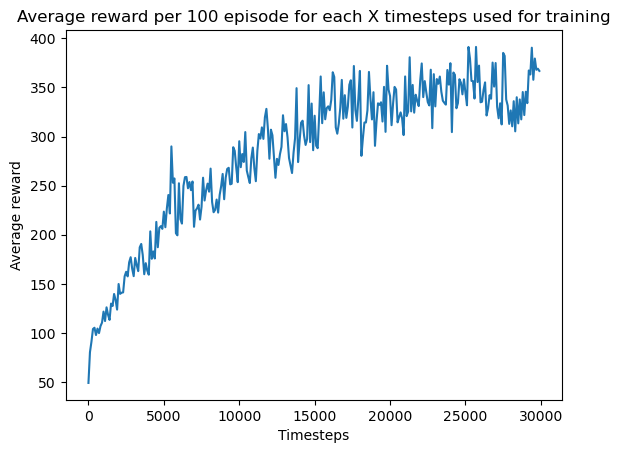

In [7]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+100]) for i in range(0, num_episodes, 100)]

# Plot the graph
plt.plot(range(0, num_episodes, 100), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 100 episode for each X timesteps used for training")

In [8]:
#TASK 1

In [9]:
# Reset the environment to get the initial observation
observation = env.reset()

# Use the bins to discretize the observation space
bins = get_bins()  # Ensure this uses the same bins as during training

# Discretize the state using the observation
state = discretize_state(observation, bins)

# Select the best action from the Q-table using the current state
# Note: No need for _, as we directly access the Q-table
action = np.argmax(q_table_trained[state])

print("Observation space is: ", observation)
print("Action taken is: ", action)



Observation space is:  [-0.00278282 -0.02971719 -0.04922795  0.00745108]
Action taken is:  0


In [10]:
#TASK 2

In [11]:
# Function to run a single episode using the trained Q-table, and return the total reward
def test_episode(env, q_table, bins):
    score = 0  # Initialize total reward for the episode
    obs = env.reset()  # Reset the environment to start a new episode
    done = False  # Initialize the 'done' condition
    while not done:
        # Discretize the state using the same bins as during training
        state = discretize_state(obs, bins)
        # Select the best action from the Q-table using the current state
        action = np.argmax(q_table[state])
        # Apply the action in the environment
        obs, reward, done, info = env.step(action)
        # Update the total reward
        score += reward
    return score

# Evaluate the trained Q-learning agent over a certain number of episodes
def evaluate_agent(env, q_table, num_episodes, bins):
    sum_episode_scores = []  # List to hold the total reward for each episode
    for episode in range(1, num_episodes + 1):
        # Run a single episode and get the total reward
        score = test_episode(env, q_table, bins)
        print(f'Episode: {episode}, Score: {score}')
        sum_episode_scores.append(score)  # Append the score for the episode to the list
    return sum_episode_scores

# Use the bins from training for discretization
bins = get_bins()

# Number of episodes to evaluate
num_test_episodes = 100

# Evaluate the agent
sum_episode_scores = evaluate_agent(env, q_table_trained, num_test_episodes, bins)

# Calculate and print the average score
average_score = np.mean(sum_episode_scores)
print(f"Average score over {num_test_episodes} episodes: {average_score:.2f}")

Episode: 1, Score: 500.0
Episode: 2, Score: 500.0
Episode: 3, Score: 500.0
Episode: 4, Score: 500.0
Episode: 5, Score: 500.0
Episode: 6, Score: 500.0
Episode: 7, Score: 500.0
Episode: 8, Score: 500.0
Episode: 9, Score: 500.0
Episode: 10, Score: 500.0
Episode: 11, Score: 500.0
Episode: 12, Score: 500.0
Episode: 13, Score: 500.0
Episode: 14, Score: 500.0
Episode: 15, Score: 500.0
Episode: 16, Score: 500.0
Episode: 17, Score: 500.0
Episode: 18, Score: 437.0
Episode: 19, Score: 326.0
Episode: 20, Score: 500.0
Episode: 21, Score: 500.0
Episode: 22, Score: 500.0
Episode: 23, Score: 500.0
Episode: 24, Score: 500.0
Episode: 25, Score: 500.0
Episode: 26, Score: 500.0
Episode: 27, Score: 487.0
Episode: 28, Score: 500.0
Episode: 29, Score: 500.0
Episode: 30, Score: 500.0
Episode: 31, Score: 500.0
Episode: 32, Score: 500.0
Episode: 33, Score: 500.0
Episode: 34, Score: 461.0
Episode: 35, Score: 500.0
Episode: 36, Score: 500.0
Episode: 37, Score: 500.0
Episode: 38, Score: 500.0
Episode: 39, Score: 5

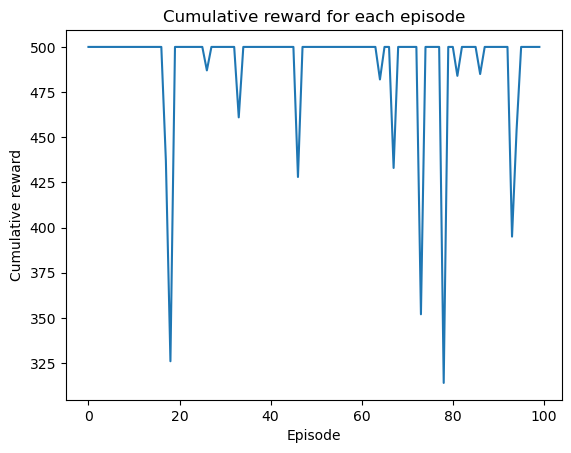

In [12]:
# Plotting the cumulative reward for each episode
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()

# Don't forget to close the environment when done
env.close()

In [13]:
#TASK 3

In [18]:
from IPython import display as ipythondisplay

# Function to display the recorded video
def show_video():
    ipythondisplay.clear_output(wait=True)
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                     loop controls style="height: 400px;">
                     <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [19]:
# Initialize your environment with video recording
env = RecordVideo(gym.make("CartPole-v1"), "video")

observation = env.reset()
total_reward = 0

# Ensure the bins are defined (same as during training)
bins = get_bins()

while True:
    # Discretize the state using the observation
    state = discretize_state(observation, bins)
    
    # Select the best action from the Q-table using the current state
    action = np.argmax(q_table_trained[state])
    
    # Apply the action in the environment
    observation, reward, done, info = env.step(action)
    total_reward += reward
    
    # Breaking the loop when the episode ends
    if done:
        break

env.close()
# Display the recorded video
show_video()

In [16]:
print("Episode reward is ", total_reward)

Episode reward is  432.0
